In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.lines as mlines
from scipy.stats import sem
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "data"

In [3]:
figurepath = Path.cwd().parent / "figures"

In [4]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [5]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [6]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th
def model(x,a,b):
    return a*x**b

In [7]:
jobids = []
params = []
data = []
data_nn = []

folders = [datapath/"xx/h = 3",datapath/"xx/h = 12",datapath/"xx/h = 24"]
files = ["combined_file_h{}.jld2".format(h) for h in [3,12,24]] 
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

folders_nn = [datapath/"xx_nn/h = 12"]
files_nn = ["combined_file_h{}.jld2".format(h) for h in [12]] 
for (i,file) in enumerate(files_nn):
    with h5py.File(folders_nn[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
for i in range(0,len(files_nn)):
    data_nn[i] = np.concatenate(data_nn[i],axis=0)
    data_nn[i] = rearrange_data(data_nn[i])

In [8]:
N = 17
T = 10 ** np.linspace(-3,1,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [9]:
res = [disorder_mean(data[i]) for i in range(len(files))]
res_sem = [disorder_sem(data[i]) for i in range(len(files))]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

res_nn = [disorder_mean(data_nn[i]) for i in range(len(files_nn))]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(len(files_nn))]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

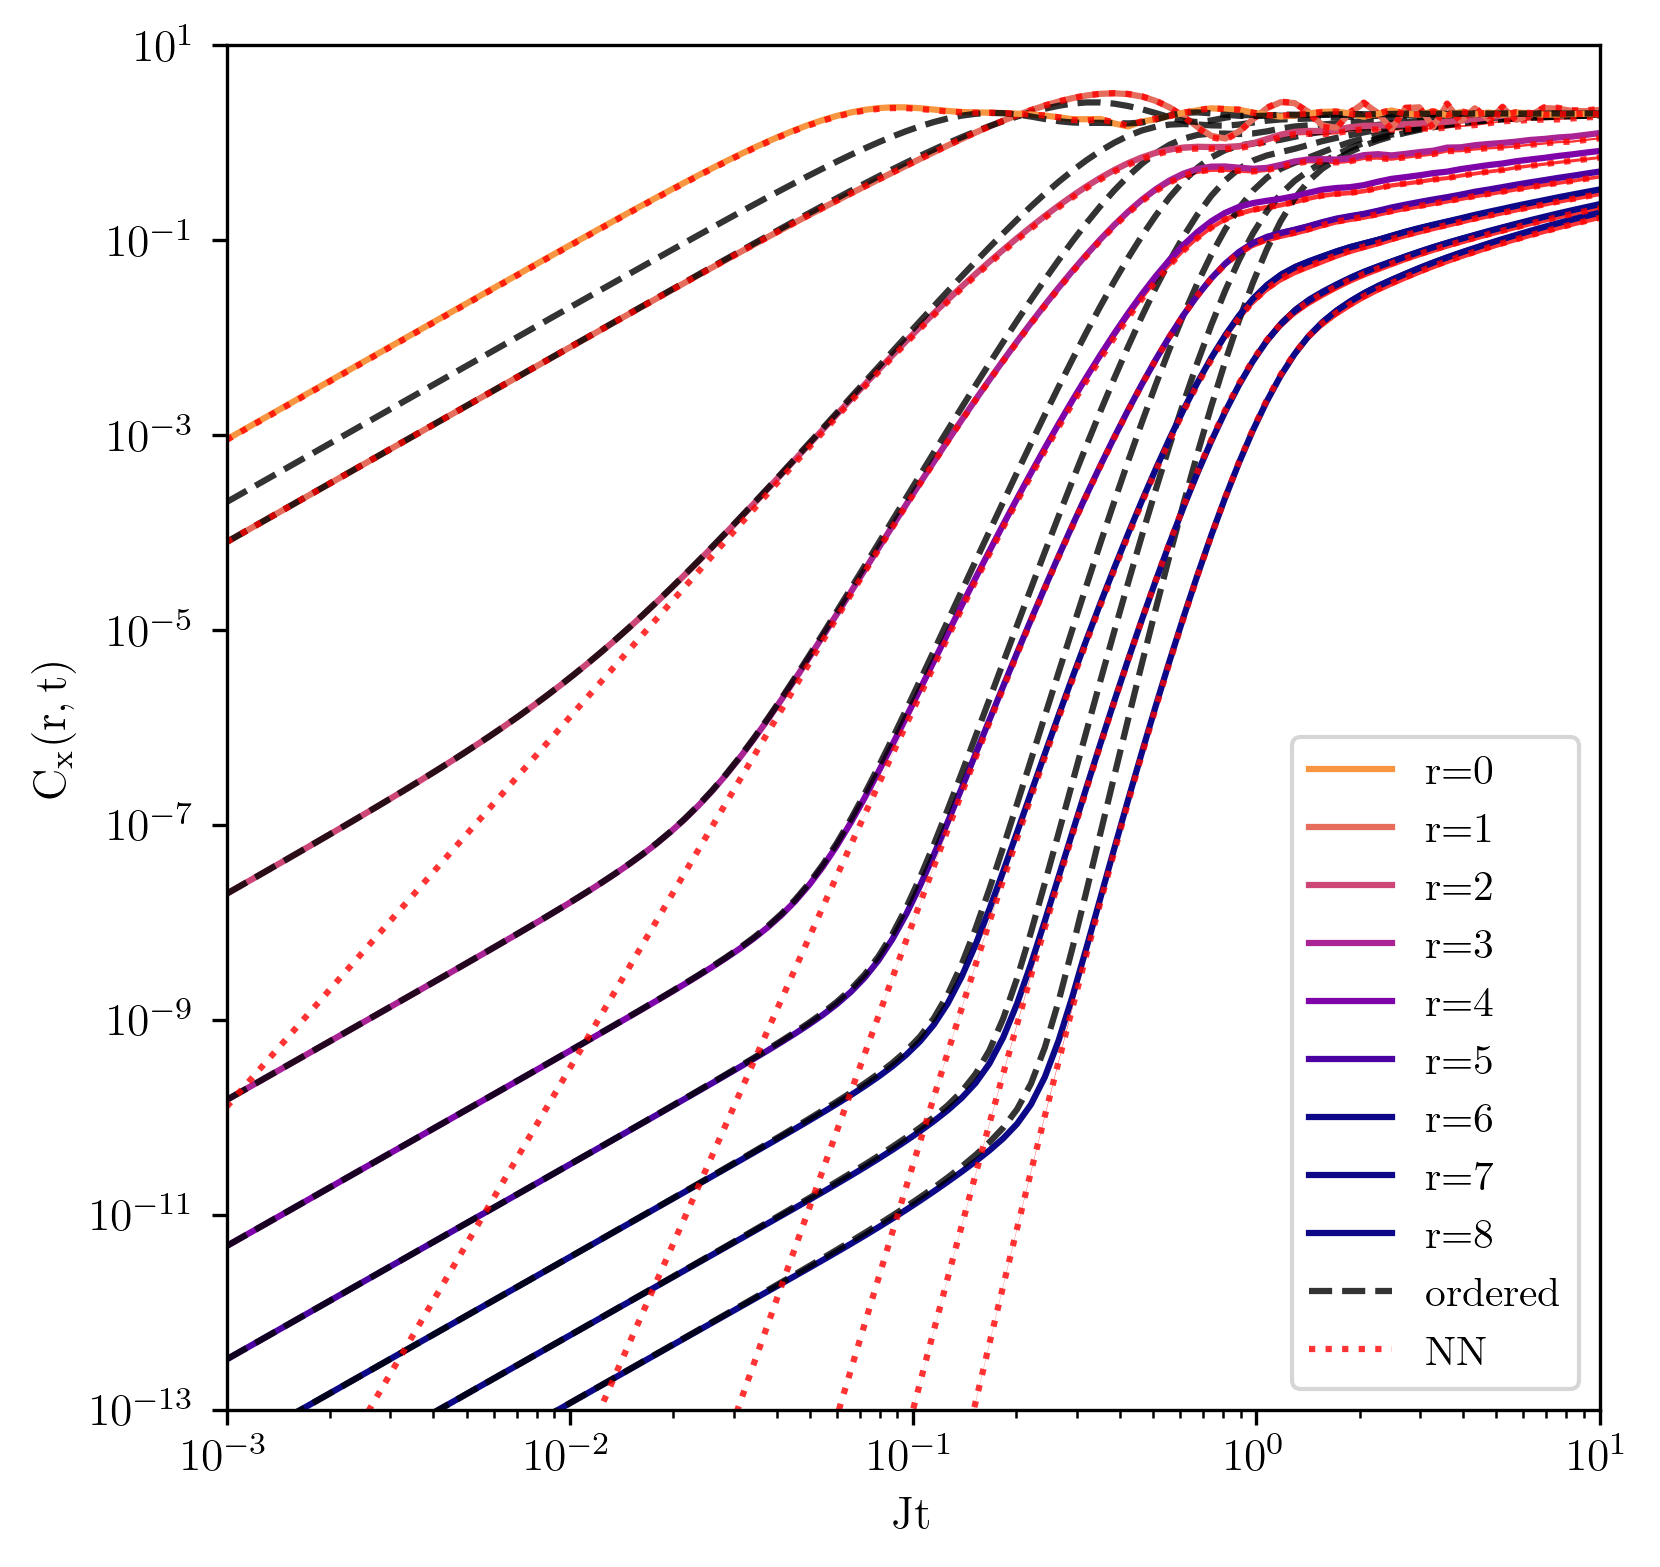

In [10]:
fig = plt.figure(figsize=set_size(),dpi=300)
ax = fig.add_subplot(111)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
ax.set_yscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[1][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red[0][:,j],c="black",ls="dashed",alpha=0.8) #h = 3
    ax.plot(T,red_nn[0][:,j],ls="dotted",c="red",alpha=0.8) #h = 12
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[1][:,j]-red_sem[1][:,j], red[1][:,j]+red_sem[1][:,j])
    ax.fill_between(T, red_nn[0][:,j]-red_sem_nn[0][:,j], red_nn[0][:,j]+red_sem_nn[0][:,j],fc="red",alpha=0.8)

black_line = mlines.Line2D([], [], color='black', ls="dashed",alpha=0.8)
red_line = mlines.Line2D([], [], color='red', ls="dotted",alpha=0.8)
handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend(handles = [handles[idx] for idx in order]+[black_line,red_line],labels = [labels[idx] for idx in order]+["ordered","NN"],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
#ax.set_title(r"h = {}, $\alpha$ = 6".format(12))
ax.set_xlim(1e-3,10)
ax.set_ylim(1e-13,10)
#ax.set_yscale("log")
plt.savefig(figurepath/"short_time_disordered.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

# Fit r = 0

In [11]:
popt = []
perr = []
tfitmax = 25
tfitmin = 0
for s in range(500):
    poptj, pcovj = curve_fit(model,T[0:tfitmax],data[1][0:tfitmax,N//2,s])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [12]:
popt_da, pcov = curve_fit(model,T[0:tfitmax],red[1][0:tfitmax,N//2])
perr_da = np.sqrt(np.diag(pcov))

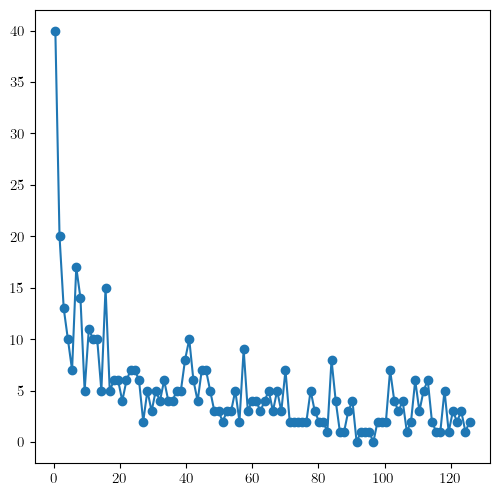

In [65]:
hs = np.zeros(500)
for s in range(500):
    hs[s] = (popt[s][0]/16-10)

p,x = np.histogram(hs,bins=100)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
plt.plot(x,p,marker="o")

In [66]:
def f(x,h):
    return 1/(2*h) * (1/(2*np.sqrt(x)))

In [80]:
dist_mean = np.nanmean(hist)
dist_median = np.median(hist)
expected = 12**2/3
disorder_average = popt_da[0]/16-10

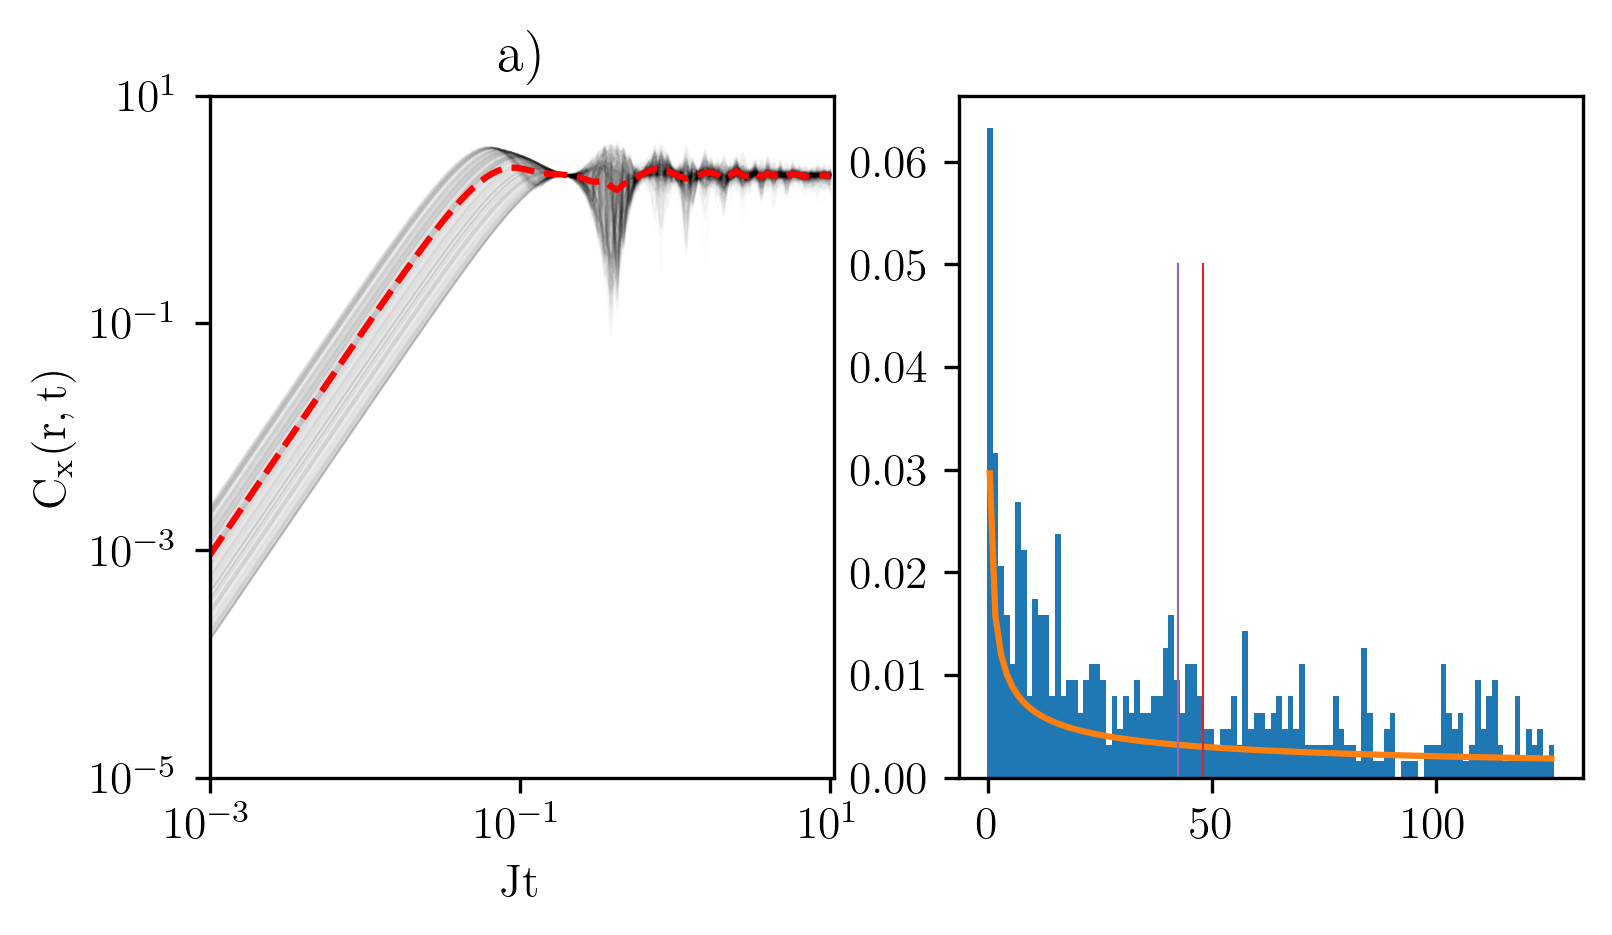

In [89]:
fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
for s in range(0,500):
    axs[0].plot(T,data[1][:,N//2,s],c="black",alpha=0.01,lw=0.5)
axs[0].plot(T,red[1][:,N//2],c="red",ls="dashed") #h = 3


axs[0].set_xlabel(r"Jt")
axs[0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0].set_title("a)")
axs[0].set_xlim(1e-3,10+0.5)
axs[0].set_ylim(1e-5,10)

axs[1].hist(hs,bins=100,density=True)
axs[1].plot(x,f(x,12))
axs[1].plot([dist_mean,dist_mean],[0,0.05],lw=0.5)
axs[1].plot([expected,expected],[0,0.05],lw=0.5)
axs[1].plot([disorder_average,disorder_average],[0,0.05],lw=0.5)

plt.savefig(figurepath/"short_time_r=0.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

# Other stuff

(2.0, 8.5)

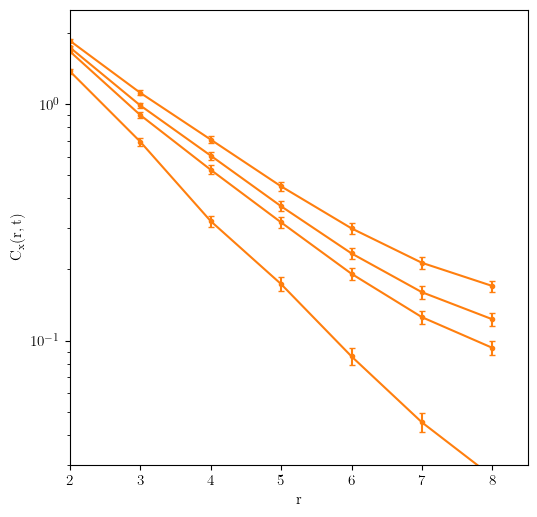

In [79]:
fig = plt.figure(figsize=set_size())
ax1 = fig.add_subplot(111)

ts1 = [2,5,7,10]
Tis1 = []
for t in ts1:
    Tis1.append(np.argmin(np.abs(T-t)))

for ti in Tis1:
    #ax1.plot(rvals[0:7],red[3][ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    #ax1.plot(rvals[0:7],red_nn[3][ti,:],label="t={:.2f}".format(T[ti]),color="C1",marker=".")
    #ax1.errorbar(rvals[0:9],red[1][ti,:],yerr=red_sem[1][ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".",capsize=2)
    ax1.errorbar(rvals[0:9],red_nn[0][ti,:],yerr=red_sem_nn[0][ti,:],label="t={:.2f}".format(T[ti]),color="C1",marker=".",capsize=2)
    #ax1.plot(rvals[0:7],5*16/rvals[0:7]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
    #ax1.fill_between(rvals[0:7], red[3][ti,:]-red_sem[3][ti,:], red[3][ti,:]+red_sem[3][ti,:],fc="C0")
    #ax1.fill_between(rvals[0:7], red_nn[3][ti,:]-red_sem_nn[3][ti,:], red_nn[3][ti,:]+red_sem_nn[3][ti,:],fc="black")

ax1.set_xlabel("r")
#ax1.set_xscale("log",base=2)
ax1.set_yscale("log")
ax1.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax1.set_ylim(3e-2,2.5)
ax1.set_xlim(2,N//2+0.5)
#ax1.set_xticks([1,2,4,6])

(0.0001, 10)

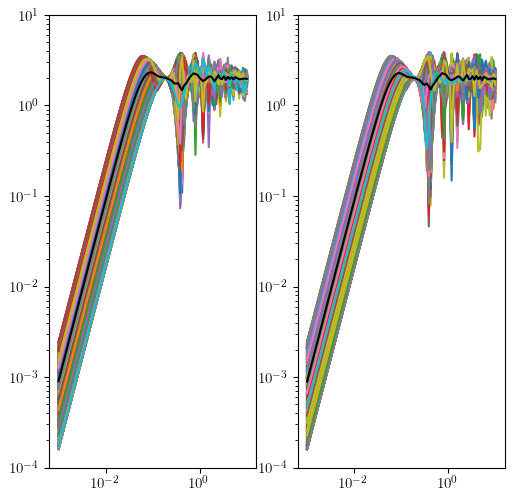

In [181]:
fig,axs = plt.subplots(1,2)
j = 8
for i in range(0,500):
    axs[0].loglog(T,data[1][:,j,i])
    axs[1].loglog(T,data_nn[0][:,j,i])

axs[0].loglog(T,red[1][:,j],c="black")
axs[1].loglog(T,red_nn[0][:,j],c="black")

axs[0].set_ylim(1e-4,10)
axs[1].set_ylim(1e-4,10)

(array([11., 15., 10., 18., 17., 12., 18., 12., 14., 16., 22., 23., 18.,
        30., 21., 30., 27., 34., 35., 25., 36., 32., 13.,  7.,  4.]),
 array([0.06842109, 0.15600489, 0.2435887 , 0.3311725 , 0.4187563 ,
        0.5063401 , 0.5939239 , 0.6815077 , 0.76909151, 0.85667531,
        0.94425911, 1.03184291, 1.11942671, 1.20701051, 1.29459432,
        1.38217812, 1.46976192, 1.55734572, 1.64492952, 1.73251332,
        1.82009712, 1.90768093, 1.99526473, 2.08284853, 2.17043233,
        2.25801613]),
 <BarContainer object of 25 artists>)

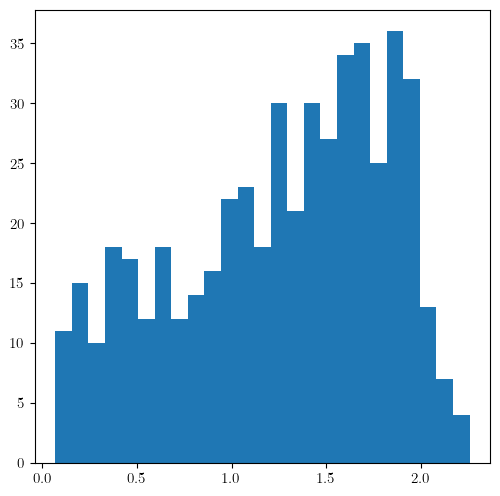

In [184]:
t = 10e0
Ti = np.argmin(np.abs(T-t))
j = 5
plt.hist(data[1][Ti,j,:],25)

In [172]:
data[1][0,8,:]

array([0.00197563, 0.00051581, 0.00076247, 0.00027055, 0.00016097,
       0.00105539, 0.00079279, 0.00104604, 0.00065599, 0.00044322,
       0.00052482, 0.00020443, 0.00197859, 0.00109808, 0.00095049,
       0.00098445, 0.00027042, 0.00129565, 0.00193757, 0.00036111,
       0.00211469, 0.00115784, 0.0021274 , 0.00037189, 0.00228252,
       0.00018116, 0.00027551, 0.00017562, 0.00069511, 0.00088774,
       0.00067406, 0.00202104, 0.00176134, 0.00023309, 0.0014247 ,
       0.00086919, 0.00044206, 0.00162403, 0.00078938, 0.00016617,
       0.00053529, 0.00209883, 0.00158566, 0.00099439, 0.00048193,
       0.00022956, 0.00058262, 0.00034515, 0.00170648, 0.0001959 ,
       0.00165726, 0.00107552, 0.00094584, 0.00043151, 0.00063557,
       0.00089547, 0.00111338, 0.00081352, 0.00077216, 0.00060657,
       0.00093525, 0.00219763, 0.00017821, 0.0014701 , 0.00018004,
       0.00082418, 0.00071456, 0.0012756 , 0.00148158, 0.00125039,
       0.00021891, 0.00191716, 0.00041609, 0.00042188, 0.00210